Mapping health research effort
-------------------------------------
Databases: 
* data
          1. All RCTs registered at WHO ICTRP by Jan 1st 2016, 
          2. with start date between 2006 and 2015
          3. with study type and design corresponding to RCT
          4. with at least one country location among the 187 countries included in the GBD2010 study
* replicates
          1. for each disease, replicates of the mapping of RCTs across diseases

We will: 
          1. Derive uncertainty intervals for the mapping of RCTs across diseases

In [1]:
#Upload database
data <- read.table("/media/igna/Elements/HotelDieu/Cochrane/Mapping_Cancer/Flowchart/database_all_diseases_final_ok.txt")
N <- nrow(data)
names(data)

[1] "TrialID"            "brief_title"        "official_title"    
 [4] "Primary_sponsor"    "Source_Register"    "Recruitment_Status"
 [7] "other_records"      "Target_size"        "Study_type"        
[10] "Study_design"       "Phase"              "Countries"         
[13] "condition"          "Secondary_ID"       "Source_Support"    
[16] "Secondary_Sponsor"  "year"               "Interv"            
[19] "Regions"            "Nb_ctr_per_reg"     "Sample"            
[22] "PMID"               "GBD28"              "GBD171"            
[25] "Infectious"         "MNN"                "Cancer"            
[28] "Chronic"

- TrialID: unique trial ID from WHOICTRP
- Regions: 7 epidemiological regions from GBD 2010 study
- GBD28: classification according to 28 categories defined in Atal et al. BMC Bioinformatics (2016): This classification includes the injuries category, we exclude it

In [2]:
#Upload traduction names/label categories
Mgbd <- read.table("/home/igna/Desktop/Programs GBD/Classifier_Trial_GBD/Databases/Taxonomy_DL/GBD_data/GBD_ICD.txt")
#And supress injuries from the causes of burden
grep("Injur",Mgbd$cause_name)
GBD27 <- sapply(strsplit(as.character(data$GBD28),"&"),function(x){paste(x[x!="28"],collapse="&")})
data$GBD27 <- GBD27

[1] 28

## 2- Estimation of number RCTs per region and disease

In [3]:
regs <- sort(unique(unlist(strsplit(as.character(data$Regions),"&"))))
LR <- lapply(regs,function(x){1:nrow(data)%in%grep(x,data$Regions)})
LR <- do.call('cbind',LR)

In [4]:
dis <- 1:27
d <- dis[1]

SMs <- list.files(paste("/media/igna/Elements/HotelDieu/Cochrane/Mapping_Cancer/Incertitude_mapping/Replicates/",as.character(d),sep=""))

In [5]:
ss_sp <- read.table(paste(c("/media/igna/Elements/HotelDieu/Cochrane/Mapping_Cancer/Incertitude_mapping/Replicates/",as.character(d),"/Sens_spec.txt"),collapse=""))


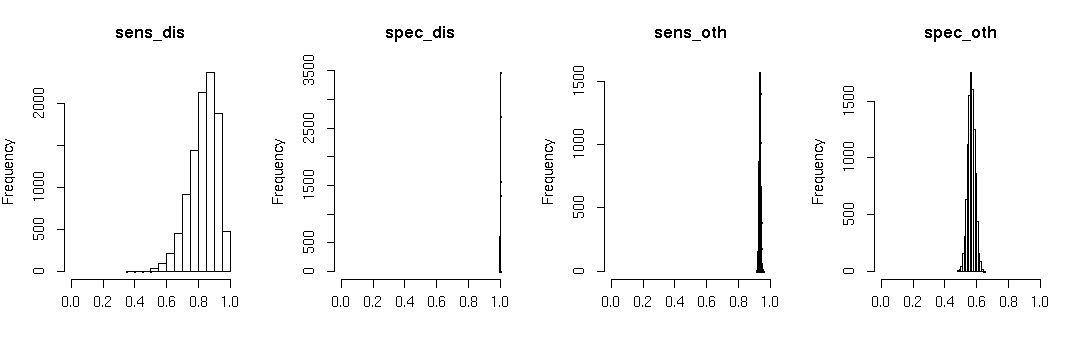

In [6]:
options(repr.plot.width=9, repr.plot.height=3)
par(mfrow=c(1,4))
for(i in 1:ncol(ss_sp)) hist(ss_sp[,i],xlim=c(0,1),main=colnames(ss_sp)[i],xlab=NULL)

In [7]:
SMs <- SMs[grep("Reclassif",SMs)]

In [8]:
length(SMs)

[1] 9903

In [9]:
k <- sample(SMs,1)

In [10]:
recl <- read.table(paste(c("/media/igna/Elements/HotelDieu/Cochrane/Mapping_Cancer/Incertitude_mapping/Replicates/",as.character(d),"/",k),collapse=""),header=TRUE)

In [11]:
head(recl)

,recl_dis,recl_oth
1,0,0
2,0,1
3,0,0
4,0,0
5,0,1
6,0,1


In [12]:
apply(LR[as.logical(recl$recl_dis),],2,sum)

[1]  11  78  24  14  38  49 106

In [15]:
apply(LR[as.logical(recl$recl_dis+recl$recl_oth),],2,sum)

[1]  6283 63596  4408  8201  4542  8898  2335

In [17]:
t0 <- proc.time()
A <- 
lapply(SMs,function(k){
    recl <- read.table(paste(c("/home/igna/Desktop/",
                               as.character(d),"/",k),collapse=""),header=TRUE)
    
    tt <- sum(recl$recl_dis)
    cbind(ifelse(tt==0,rep(0,length(regs)),
          ifelse(tt==1,as.numeric(LR[as.logical(recl$recl_dis),]),
          apply(LR[as.logical(recl$recl_dis),],2,sum))),
    apply(LR[as.logical(recl$recl_dis+recl$recl_oth),],2,sum))
    
})
t1 <- proc.time()

In [18]:
(t1-t0)/60

       user      system     elapsed 
24.71081667  0.07793333 25.34556667 

In [19]:
library(parallel)

In [20]:
detectCores()

[1] 4

In [21]:
library(foreach)
library(doParallel)

Loading required package: iterators


In [22]:

cl<-makeCluster(4)
registerDoParallel(cl)

t0 <- proc.time()
A <- foreach(k = SMs) %dopar% {
    recl <- read.table(paste(c("/home/igna/Desktop/",
                               as.character(d),"/",k),collapse=""),header=TRUE)
    
    tt <- sum(recl$recl_dis)
    cbind(ifelse(tt==0,rep(0,length(regs)),
          ifelse(tt==1,as.numeric(LR[as.logical(recl$recl_dis),]),
          apply(LR[as.logical(recl$recl_dis),],2,sum))),
    apply(LR[as.logical(recl$recl_dis+recl$recl_oth),],2,sum))
}

t1 <- proc.time()-t0

stopCluster(cl)



In [23]:
t1/60

        user       system      elapsed 
 0.150300000  0.007666667 10.509900000 

In [48]:

cl<-makeCluster(8)
registerDoParallel(cl)

t0 <- proc.time()
A <- foreach(k = SMs) %dopar% {
    recl <- read.table(paste(c("/media/igna/Elements/HotelDieu/Cochrane/Mapping_Cancer/Incertitude_mapping/Replicates/",
                               as.character(d),"/",k),collapse=""),header=TRUE)
    
    tt <- sum(recl$recl_dis)
    cbind(unlist(ifelse(tt==0,list(rep(0,length(regs))),
          ifelse(tt==1,list(as.numeric(LR[as.logical(recl$recl_dis),])),
          list(apply(LR[as.logical(recl$recl_dis),],2,sum))))),
    apply(LR[as.logical(recl$recl_dis+recl$recl_oth),],2,sum))
}

t1 <- proc.time()-t0

stopCluster(cl)



In [49]:
t1/60

       user      system     elapsed 
0.140800000 0.007466667 9.953133333 

In [45]:
head(A)

21,6104
105,62046
34,4315
18,7932
52,4497
68,8709
138,2303
23,5963
153,60737
40,4137
33,7771


In [47]:
(t1/60)*27/60

     user    system   elapsed 
0.0581400 0.0028425 4.6945725 

In [42]:
k <- SMs[1]
    recl <- read.table(paste(c("/media/igna/Elements/HotelDieu/Cochrane/Mapping_Cancer/Incertitude_mapping/Replicates/",
                               as.character(d),"/",k),collapse=""),header=TRUE)
    
    tt <- sum(recl$recl_dis)
    cbind(unlist(ifelse(tt==0,list(rep(0,length(regs))),
          ifelse(tt==1,list(as.numeric(LR[as.logical(recl$recl_dis),])),
          list(apply(LR[as.logical(recl$recl_dis),],2,sum))))),
    apply(LR[as.logical(recl$recl_dis+recl$recl_oth),],2,sum))


21,6104
105,62046
34,4315
18,7932
52,4497
68,8709
138,2303


In [27]:
apply(LR[as.logical(recl$recl_dis),],2,sum)

[1]  21 105  34  18  52  68 138

In [28]:
apply(LR[as.logical(recl$recl_dis+recl$recl_oth),],2,sum)

[1]  6104 62046  4315  7932  4497  8709  2303

In [29]:
cbind(apply(LR[as.logical(recl$recl_dis),],2,sum),apply(LR[as.logical(recl$recl_dis+recl$recl_oth),],2,sum))

21,6104
105,62046
34,4315
18,7932
52,4497
68,8709
138,2303


In [32]:
ifelse(tt==0,rep(0,length(regs)),
          ifelse(tt==1,as.numeric(LR[as.logical(recl$recl_dis),]),
          apply(LR[as.logical(recl$recl_dis),],2,sum)))

ERROR: Error in parse(text = x, srcfile = src): <text>:4:0: unexpected end of input
2:           ifelse(tt==1,as.numeric(LR[as.logical(recl$recl_dis),]),
3:           c(apply(LR[as.logical(recl$recl_dis),],2,sum)))
  ^


In [41]:
tt <- 2
unlist(ifelse(tt==0,list(rep(0,length(regs))),
          ifelse(tt==1,list(as.numeric(LR[as.logical(recl$recl_dis),])),
          list(apply(LR[as.logical(recl$recl_dis),],2,sum)))))

[1]  21 105  34  18  52  68 138

In [34]:
length(regs)

[1] 7

In [35]:
rep(0,length(regs))

[1] 0 0 0 0 0 0 0